# Recommendation System
## Problem Statement

Your client is a fast-growing mobile platform, for hosting coding challenges. They have a unique business model, where they crowdsource problems from various creators(authors). These authors create the problem and release it on the client's platform. The users then select the challenges they want to solve. The authors make money based on the level of difficulty of their problems and how many users take up their challenge.
 
The client, on the other hand makes money when the users can find challenges of their interest and continue to stay on the platform. Till date, the client has relied on its domain expertise, user interface and experience with user behaviour to suggest the problems a user might be interested in. You have now been appointed as the data scientist who needs to come up with the algorithm to keep the users engaged on the platform.
The client has provided you with history of last 10 challenges the user has solved, and you need to predict which might be the next 3 challenges the user might be interested to solve. Apply your data science skills to help the client make a big mark in their user engagements/revenue.

## Notice:

Below codes still need to optimize to save memory. The program cannot complete the execution in an i7 with 16GB RAM Windows 10 platform.

## DATASET DESCRIPTION
### We have three data files:
##### train.csv: It contains the set of 13 challenges that were attempted by the same user in a sequence 

|Variable | Definition|
|------------- |-------------|
|user_sequence|Unique ID for the sequence|
|user_id|User ID|
|challenge_sequence|Challenge sequence number (1-13)|
|challenge|Challenge ID|

##### challenge_data.csv: Contains attributes related to each challenge
|Variable|Definition|
|------------- |-------------|
|challenge_ID|Challenge ID|
|programming_language|Programming language for the challenge|
|challenge_series_ID|Series for the given challenge|
|total_submissions|Total submissions by all users|
|publish_date|Publishing date for the challenge|
|author_ID|Author ID|
|author_gender|Author gender|
|author_org_ID|Organization ID for author|
|category_id|Type of challenge|

##### test.csv:  
Contains the first 10 challenges solved by a new user set (not in train) in the test set. We need to predict the next 3 sequence of challenges for these users.

|Variable|Definition|
|------------- |-------------|
|user_sequence|Unique ID for the sequence|
|user_id|User ID|
|challenge_sequence|Challenge sequence number (1-10)|
|challenge|Challenge ID|

##### sample_submission.csv:  
It contains the format for submission. Only submissions in this format are acceptable. This should have the next 3 challenges for each user.

|Variable|Definition|
|------------- |-------------|
|user_sequence|Unique ID for the sequence (See Note)|
|challenge|Challenge ID|

###### Note: The format is given by "user_id_challenge_sequence". For example, for user ID 2 you must predict the next 3 challenges with sequence 11, 12 and 13 respectively. The corresponding user_sequence would be given by 2_11, 2_12 & 2_13.


In [3]:
%matplotlib inline
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from ast import literal_eval
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet
from surprise import Reader, Dataset, SVD, SVDpp, evaluate
from surprise.model_selection import cross_validate

import warnings; warnings.simplefilter('ignore')

In [2]:
df_challenge = pd.read_csv('challenge_data-revised.csv')
df_challenge.head()

,challenge_ID,programming_language,challenge_series_ID,total_submissions,publish_date,author_ID,author_gender,author_org_ID,category_id
0,CI23478,2,SI2445,37.0,06-05-2006,AI563576,M,AOI100001,NaN
1,CI23479,2,SI2435,48.0,17-10-2002,AI563577,M,AOI100002,32.0
2,CI23480,1,SI2435,15.0,16-10-2002,AI563578,M,AOI100003,NaN
3,CI23481,1,SI2710,236.0,19-09-2003,AI563579,M,AOI100004,70.0
4,CI23482,2,SI2440,137.0,21-03-2002,AI563580,M,AOI100005,NaN


In [3]:
df_challenge.tail()

,challenge_ID,programming_language,challenge_series_ID,total_submissions,publish_date,author_ID,author_gender,author_org_ID,category_id
5601,CI29079,1,SI2864,NaN,17-06-2010,AI567059,M,AOI101717,29.0
5602,CI29080,1,SI2865,NaN,25-06-2010,AI567060,F,AOI101718,29.0
5603,CI29081,1,SI2865,NaN,25-06-2010,AI566257,M,AOI100108,29.0
5604,CI29082,1,SI2865,NaN,25-06-2010,AI563777,M,AOI100108,29.0
5605,CI29083,1,SI2865,NaN,25-06-2010,AI564006,F,AOI100022,29.0


In [4]:
df_train = pd.read_csv('train.csv')
df_train.head()

,user_sequence,user_id,challenge_sequence,challenge
0,4576_1,4576,1,CI23714
1,4576_2,4576,2,CI23855
2,4576_3,4576,3,CI24917
3,4576_4,4576,4,CI23663
4,4576_5,4576,5,CI23933


In [5]:
df_test = pd.read_csv('test.csv')
df_test.head()

,user_sequence,user_id,challenge_sequence,challenge
0,4577_1,4577,1,CI23855
1,4577_2,4577,2,CI23933
2,4577_3,4577,3,CI24917
3,4577_4,4577,4,CI24915
4,4577_5,4577,5,CI23714


## Content Based Recommender

Computes similarity between challenges based on certain metrics and suggests challenges that are most similar to a particular challenge that a user liked. the challenge metadata (or content) will be used to build this engine, this also known as Content Based Filtering.

Two Content Based Recommenders based on:

    programming_language, author id, category id, total_submissions
    programming_language, author id, author gender, author org, category id, total_submissions.

In [6]:
df_challenge.shape

(5606, 9)

In [7]:
df_challenge.isnull().any()

challenge_ID            False
programming_language    False
challenge_series_ID     False
total_submissions        True
publish_date            False
author_ID                True
author_gender            True
author_org_ID            True
category_id              True
dtype: bool

In [8]:
df_challenge['publish_date'] = pd.to_datetime(df_challenge['publish_date'])
df_challenge.tail()

,challenge_ID,programming_language,challenge_series_ID,total_submissions,publish_date,author_ID,author_gender,author_org_ID,category_id
5601,CI29079,1,SI2864,NaN,2010-06-17,AI567059,M,AOI101717,29.0
5602,CI29080,1,SI2865,NaN,2010-06-25,AI567060,F,AOI101718,29.0
5603,CI29081,1,SI2865,NaN,2010-06-25,AI566257,M,AOI100108,29.0
5604,CI29082,1,SI2865,NaN,2010-06-25,AI563777,M,AOI100108,29.0
5605,CI29083,1,SI2865,NaN,2010-06-25,AI564006,F,AOI100022,29.0


### Check null values

In [9]:
df_challenge.isnull().any()

challenge_ID            False
programming_language    False
challenge_series_ID     False
total_submissions        True
publish_date            False
author_ID                True
author_gender            True
author_org_ID            True
category_id              True
dtype: bool

## Data Cleaning
### total_submissions

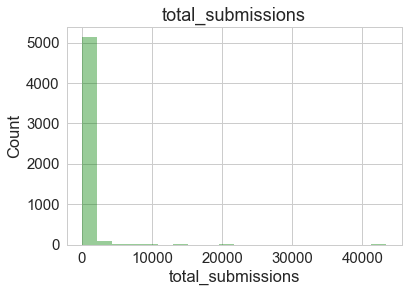

In [10]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(df_challenge["total_submissions"].dropna(),
                 bins=20,
                 kde=False,
                 color="green")
    plt.title("total_submissions")
    plt.ylabel("Count")
    

In [11]:
print('total_submissions=> mean =%f, median=%f'%(df_challenge["total_submissions"].mean(), df_challenge["total_submissions"].median()))
df_challenge["total_submissions"].describe()

total_submissions=> mean =348.362581, median=134.000000


count     5254.000000
mean       348.362581
std       1044.810816
min          2.000000
25%         67.000000
50%        134.000000
75%        297.000000
max      43409.000000
Name: total_submissions, dtype: float64

In [12]:
df_challenge["total_submissions"].isna().sum()

352

### Data cleaning for total submissions.
The latest challenges do not have the number, use median number to fillin.

In [13]:
# Assign missing total_submissions to median number
df_challenge["total_submissions"] = df_challenge["total_submissions"].fillna(value=122)
df_challenge.tail()

,challenge_ID,programming_language,challenge_series_ID,total_submissions,publish_date,author_ID,author_gender,author_org_ID,category_id
5601,CI29079,1,SI2864,122.0,2010-06-17,AI567059,M,AOI101717,29.0
5602,CI29080,1,SI2865,122.0,2010-06-25,AI567060,F,AOI101718,29.0
5603,CI29081,1,SI2865,122.0,2010-06-25,AI566257,M,AOI100108,29.0
5604,CI29082,1,SI2865,122.0,2010-06-25,AI563777,M,AOI100108,29.0
5605,CI29083,1,SI2865,122.0,2010-06-25,AI564006,F,AOI100022,29.0


### Challenge series id

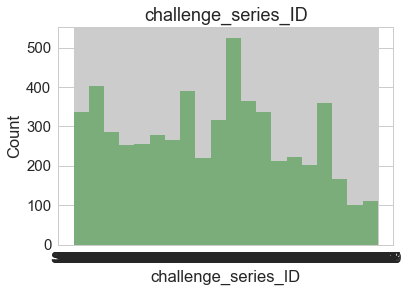

In [14]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(df_challenge["challenge_series_ID"].dropna(),
                 bins=20,
                 kde=False,
                 color="green")
    plt.title("challenge_series_ID")
    plt.ylabel("Count")
    

In [15]:
df_challenge["challenge_series_ID"].isna().sum()

0

### Use mode number of series_id for missing data
Manually add the series id by previous value

In [16]:
 df_challenge["challenge_series_ID"].mode()

0    SI2652
dtype: object

In [17]:
df_challenge["challenge_series_ID"] = df_challenge["challenge_series_ID"].fillna(value='SI2652')
df_challenge.tail()

,challenge_ID,programming_language,challenge_series_ID,total_submissions,publish_date,author_ID,author_gender,author_org_ID,category_id
5601,CI29079,1,SI2864,122.0,2010-06-17,AI567059,M,AOI101717,29.0
5602,CI29080,1,SI2865,122.0,2010-06-25,AI567060,F,AOI101718,29.0
5603,CI29081,1,SI2865,122.0,2010-06-25,AI566257,M,AOI100108,29.0
5604,CI29082,1,SI2865,122.0,2010-06-25,AI563777,M,AOI100108,29.0
5605,CI29083,1,SI2865,122.0,2010-06-25,AI564006,F,AOI100022,29.0


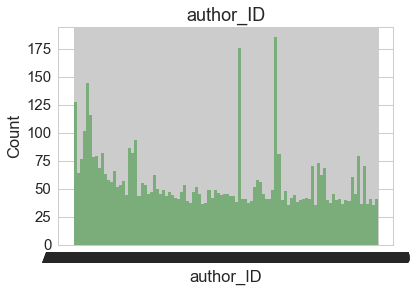

In [18]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(df_challenge["author_ID"].dropna(),
                 bins=100,
                 kde=False,
                 color="green")
    plt.title("author_ID")
    plt.ylabel("Count")

In [19]:
 df_challenge["author_ID"].mode()

0    AI565468
dtype: object

In [20]:
df_challenge["author_ID"] = df_challenge["author_ID"].fillna(value='AI565468')

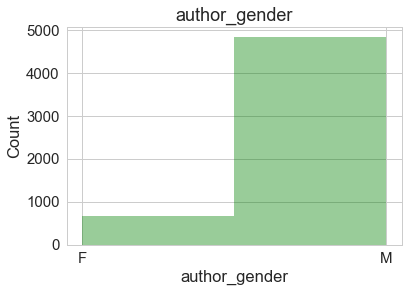

In [21]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(df_challenge["author_gender"].dropna(),
                 bins=2,
                 kde=False,
                 color="green")
    plt.title("author_gender")
    plt.ylabel("Count")

In [22]:
df_challenge["author_gender"] = df_challenge["author_gender"].fillna(value='M')

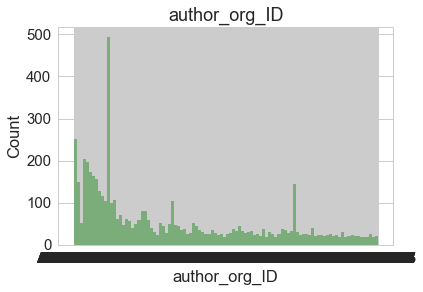

In [23]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(df_challenge["author_org_ID"].dropna(),
                 bins=100,
                 kde=False,
                 color="green")
    plt.title("author_org_ID")
    plt.ylabel("Count")

In [24]:
df_challenge["author_org_ID"].mode()

0    AOI100201
dtype: object

In [25]:
df_challenge["author_org_ID"] = df_challenge["author_org_ID"].fillna(value='AOI100201')

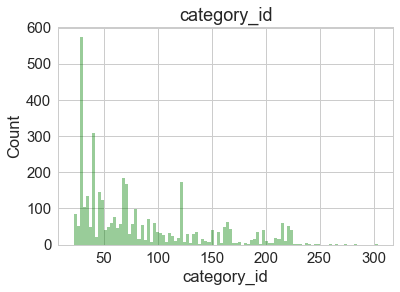

In [26]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(df_challenge["category_id"].dropna(),
                 bins=100,
                 kde=False,
                 color="green")
    plt.title("category_id")
    plt.ylabel("Count")

In [27]:
df_challenge["category_id"].mode()

0    29.0
dtype: float64

In [28]:
df_challenge["category_id"] = df_challenge["category_id"].fillna(value=29)

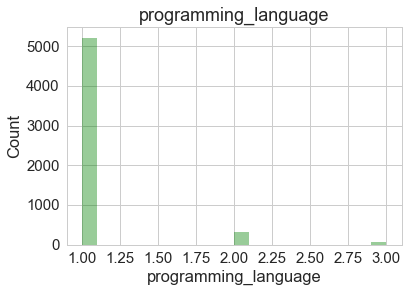

In [29]:
with sns.plotting_context("notebook",font_scale=1.5):
    sns.set_style("whitegrid")
    sns.distplot(df_challenge["programming_language"].dropna(),
                 bins=20,
                 kde=False,
                 color="green")
    plt.title("programming_language")
    plt.ylabel("Count")

In [30]:
df_challenge.isnull().any()

challenge_ID            False
programming_language    False
challenge_series_ID     False
total_submissions       False
publish_date            False
author_ID               False
author_gender           False
author_org_ID           False
category_id             False
dtype: bool

## Metadata Based Recommender

To build the standard metadata based content recommender, merging current dataset with the crew and the keyword datasets. 

Data preparation as first step.

## Collaborative Filtering

Due to the lack of data content and distribution, the above based engine suffers from some severe limitations. 
It is only capable of suggesting challenges which are close to a certain challenge. 
That is, it is not capable of capturing tastes and providing recommendations across genres.
Also, the engine is not really personal in that it doesn't capture the personal tastes and biases of a user. 
Anyone querying the engine for recommendations based on a challenge will receive the same recommendations for tmovie, regardless of who s/he is.

Therefore, in this section, a technique called Collaborative Filtering will be used to make recommendations to users. 
Collaborative Filtering is based on the idea that users similar to a me can be used to predict how much I will like a particular product or service those users have used/experienced but I have not.
The Surprise library provides algorithms like Singular Value Decomposition (SVD) to minimise RMSE (Root Mean Square Error) and give great recommendations.


### Define our precision function 

The evaluation metric is Mean Average Precision (MAP) at K (K = 3). MAP is a well-known metric used to evaluate ranked retrieval results

In [31]:
from collections import defaultdict

from surprise import Dataset
from surprise import SVD
from surprise.model_selection import KFold


def precision_recall_at_k(predictions, k=13, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls


### Define our function to recommend top n challenge

In [32]:
def get_top_n(predictions, n=3):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 3.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

#### Adjust challenge sequence to ranking by 14-challenge_sequence

In [33]:
reader = Reader(rating_scale=(1,13))

# Combine training and testing dataset
frames = [df_train, df_test]
df = pd.concat(frames)
ratings = df.copy(deep=True)
ratings['challenge_sequence'] = 14-ratings['challenge_sequence']
ratings.head()


,user_sequence,user_id,challenge_sequence,challenge
0,4576_1,4576,13,CI23714
1,4576_2,4576,12,CI23855
2,4576_3,4576,11,CI24917
3,4576_4,4576,10,CI23663
4,4576_5,4576,9,CI23933


#### Using n-folds, n = 5, to perform cross validation.

In [34]:
n_folds = 5
data = Dataset.load_from_df(ratings[['user_id', 'challenge', 'challenge_sequence']], reader)

### Select algorithm for prediction

In [35]:
algo = SVDpp()

#Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=['FCP', 'RMSE', 'MAE'], cv=n_folds, verbose=True)

Evaluating FCP, RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
FCP (testset)     0.5955  0.5953  0.5946  0.5960  0.5952  0.5953  0.0005  
RMSE (testset)    3.3193  3.3123  3.2993  3.3059  3.3108  3.3095  0.0067  
MAE (testset)     2.5820  2.5787  2.5711  2.5768  2.5822  2.5781  0.0041  
Fit time          600.48  605.49  610.17  606.52  276.01  539.73  131.90  
Test time         17.65   15.61   16.34   15.04   6.54    14.24   3.95    


{'fit_time': (600.4766566753387,
  605.4902696609497,
  610.1671254634857,
  606.5244348049164,
  276.0096118450165),
 'test_fcp': array([0.59549265, 0.59525893, 0.5945876 , 0.59600783, 0.59515513]),
 'test_mae': array([2.58197824, 2.57871009, 2.57106366, 2.57676066, 2.5822106 ]),
 'test_rmse': array([3.31931163, 3.31230971, 3.29934145, 3.30592659, 3.31084098]),
 'test_time': (17.649951219558716,
  15.60952353477478,
  16.343475341796875,
  15.04062032699585,
  6.542790174484253)}

In [36]:
algo = SVD()

#Run 5-fold cross-validation and print results
cross_validate(algo, data, measures=['FCP', 'RMSE', 'MAE'], cv=n_folds, verbose=True)

Evaluating FCP, RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
FCP (testset)     0.5828  0.5807  0.5808  0.5799  0.5821  0.5813  0.0010  
RMSE (testset)    3.2707  3.2714  3.2704  3.2680  3.2634  3.2688  0.0029  
MAE (testset)     2.7022  2.7063  2.7021  2.7013  2.6959  2.7016  0.0033  
Fit time          177.64  183.66  186.75  183.50  95.76   165.46  34.97   
Test time         5.83    6.06    4.47    3.35    2.39    4.42    1.41    


{'fit_time': (177.6418435573578,
  183.66005778312683,
  186.74927592277527,
  183.49513268470764,
  95.76461338996887),
 'test_fcp': array([0.58276264, 0.58073649, 0.580773  , 0.57990113, 0.5820837 ]),
 'test_mae': array([2.70223029, 2.70627739, 2.70209882, 2.70128537, 2.69588259]),
 'test_rmse': array([3.27065838, 3.27137378, 3.27036387, 3.26804422, 3.26341703]),
 'test_time': (5.831512212753296,
  6.057112693786621,
  4.474903583526611,
  3.351712465286255,
  2.386348247528076)}

### Evaluate by AP@K=13


In [37]:
ap_k = 13

In [38]:
kf = KFold(n_splits=n_folds)
algo = SVD()

for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=ap_k, threshold=13)

    # Precision and recall can then be averaged over all users
    print('precisions=%f'%(sum(prec for prec in precisions.values()) / len(precisions)))
    print('recalls=%f'%(sum(rec for rec in recalls.values()) / len(recalls)))
    

precisions=0.999763
recalls=0.782874
precisions=0.999683
recalls=0.785015
precisions=0.999723
recalls=0.785952
precisions=0.999694
recalls=0.783160
precisions=0.999753
recalls=0.784516


In [39]:
kf = KFold(n_splits=n_folds)
algo = SVDpp()

for trainset, testset in kf.split(data):
    algo.fit(trainset)
    predictions = algo.test(testset)
    precisions, recalls = precision_recall_at_k(predictions, k=ap_k, threshold=4)

    # Precision and recall can then be averaged over all users
    print('precisions=%f'%(sum(prec for prec in precisions.values()) / len(precisions)))
    print('recalls=%f'%(sum(rec for rec in recalls.values()) / len(recalls)))

precisions=0.881019
recalls=0.930159
precisions=0.880099
recalls=0.930480
precisions=0.880601
recalls=0.930825
precisions=0.882002
recalls=0.929146
precisions=0.881063
recalls=0.930856


#### According to above testing, SVDpp provides better balance on precision and recall

Choose SVDpp as major algorithm.

### Train the data

In [40]:
algo = SVDpp()

In [41]:
trainset = data.build_full_trainset()
algo.train(trainset)

#### Let us pick first user and check the ratings s/he has given.

In [42]:
ratings[ratings['user_id'] == 4576]

,user_sequence,user_id,challenge_sequence,challenge
0,4576_1,4576,13,CI23714
1,4576_2,4576,12,CI23855
2,4576_3,4576,11,CI24917
3,4576_4,4576,10,CI23663
4,4576_5,4576,9,CI23933
5,4576_6,4576,8,CI25135
6,4576_7,4576,7,CI23975
7,4576_8,4576,6,CI25126
8,4576_9,4576,5,CI24915
9,4576_10,4576,4,CI24957


In [5]:
algo.predict(4576, 'CI23855', 12)

Prediction(uid=4576, iid='CI23855', r_ui=12, est=11.400594668750657, details={'was_impossible': False})

### Make Prediction on testing set

In [44]:
trainset = data.build_full_trainset()
algo.fit(trainset)

#### Unmark below code to store / retrive above result into disk to save computing time for rest of procedures.

In [4]:

# with open(r'./trainset.pkl', 'wb') as afile:
#     pickle.dump(trainset, afile, protocol=pickle.HIGHEST_PROTOCOL)
# afile.close()

# with afile = open(r'./algo.pkl', 'wb') as afile:
#     pickle.dump(algo, afile, protocol=pickle.HIGHEST_PROTOCOL)
# afile.close()

# # reload object from file
# with open('./trainset.pkl', 'rb') as file2:
#     trainset = pickle.load(file2)
# file2.close()

# with open('./algo.pkl', 'rb') as file2:
#     algo = pickle.load(file2)
# file2.close()


In [47]:
# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()

In [ ]:
# with open('./testset.pkl', 'wb') as afile:
#     pickle.dump(testset, afile, protocol=pickle.HIGHEST_PROTOCOL)

# afile.close()

##reload object from file
# with open(r'./testset.pkl', 'rb') file2 as:
#     testset = pickle.load(file2)
# file2.close()

In [ ]:
df_test.set_index(['user_id'])

new_test_data = list()
## List down partial data for checking if required.
# i = 0
# for item in testset:
#     print('item[0]=%s'%(item[0]))
#     i += 1
#     if i > 5: continue
        
for item in testset:
    if item[0] in df_test.index:
        new_test_data.append(item)
    else: pass
    
        
        

In [ ]:
# with open('./newtestset.pkl', 'wb') as afile:
#     pickle.dump(new_test_data, afile, protocol=pickle.HIGHEST_PROTOCOL)
# afile.close()

##reload object from file
# with open('./newtestset.pkl', 'rb') as file2:
#     newtestset = pickle.load(file2)
# file2.close()

In [ ]:
predictions = algo.test(new_test_data)

# with open('./predictions.pkl', 'wb') as afile:
#     pickle.dump(predictions, afile, protocol=pickle.HIGHEST_PROTOCOL)
# afile.close()

In [ ]:
top_n = get_top_n(predictions, n=3)

# Print the recommended items for each user, only get first 7 users as example to view the results.
i = 0
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])
    i += 1
    if i > 21: continue